In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import psycopg2

import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from data_pipeline.EntryDataCleaning import EntryDataCleaning

NEON_URI = os.environ.get("DB_URI_NEON")
NEON_PASSWORD = os.environ.get("DB_PASSWORD_NEON")
if not NEON_URI or not NEON_PASSWORD:
    raise "DB_URI_NEON and DB_PASSWORD_NEON environment variables must be set"

NEON_CONNECTION_URI = f"postgresql+psycopg2://FlatsDB_owner:{NEON_PASSWORD}@{NEON_URI}/FlatsDB?sslmode=require" if NEON_URI and NEON_PASSWORD else None

In [2]:
engine = create_engine(NEON_CONNECTION_URI)
Session = sessionmaker(bind=engine)

In [3]:
def get_all_offers() -> pd.DataFrame:
    Q_GET_OFFERS = """
    SELECT *
    FROM offers;
    """    
    with Session() as session:
        res = session.execute(text(Q_GET_OFFERS))
        df = pd.DataFrame(res.fetchall())
        df.index = df["id"]
        df.drop("id", axis=1, inplace=True)
        df = df.replace("-1", np.nan)
        return df

In [4]:
dcleaning = EntryDataCleaning(get_all_offers())
df = dcleaning.run()

In [8]:
df.head()

,url_id,price,area,rooms,floor,floor_num,construction_status,ownership,build_year,balcony,...,lift,garage,market,offer_type,city,voivodeship,longitude,latitude,created_at,modified_at
id,,,,,,,,,,,,,,,,,,,,,
4,142277,259000,41.97,2,1,4,ready_to_use,full_ownership,NaN,1,...,0,0,secondary,mieszkanie,Wałbrzych,dolnośląskie,16.276918,50.811157,2024-09-30 13:47:02+00:00,2024-10-30 15:01:25+00:00
5,120108,389000,63.36,3,1,7,ready_to_use,limited_ownership,1986,0,...,1,0,secondary,mieszkanie,Bydgoszcz,kujawsko-pomorskie,18.129560,53.151440,2024-04-14 20:25:22+00:00,2024-10-30 08:19:33+00:00
6,142666,495000,48.20,3,9,10,to_renovation,limited_ownership,1967,1,...,1,0,secondary,mieszkanie,Poznań,wielkopolskie,16.907310,52.371820,2024-09-30 09:11:21+00:00,2024-10-30 10:16:07+00:00
7,159406,552628,54.91,3,5,8,to_completion,full_ownership,2026,1,...,1,0,primary,mieszkanie,Poznań,wielkopolskie,16.949863,52.375072,2024-10-16 19:45:37+00:00,2024-11-02 10:30:36+00:00
8,80447,400000,35.60,1,3,5,ready_to_use,full_ownership,2000,0,...,0,0,secondary,mieszkanie,Poznań,wielkopolskie,16.911043,52.389239,2024-10-04 10:29:06+00:00,2024-10-31 08:53:33+00:00


In [ ]:
class FilterOutliers:

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def floor_num(self) -> None:
        self.df = self.df[(self.df["floor_num"] >= "1") & (self.df["floor_num"] <= "24") | (self.df["floor_num"].isna())]
        return self

    
    

In [99]:
df.columns

Index(['url_id', 'price', 'area', 'rooms', 'floor', 'floor_num',
       'construction_status', 'ownership', 'build_year', 'balcony', 'terrace',
       'lift', 'garage', 'market', 'offer_type', 'city', 'voivodeship',
       'longitude', 'latitude', 'created_at', 'modified_at'],
      dtype='object')

In [145]:
NUMERICAL_COLS = ["price", "area", "floor_num", "build_year"]

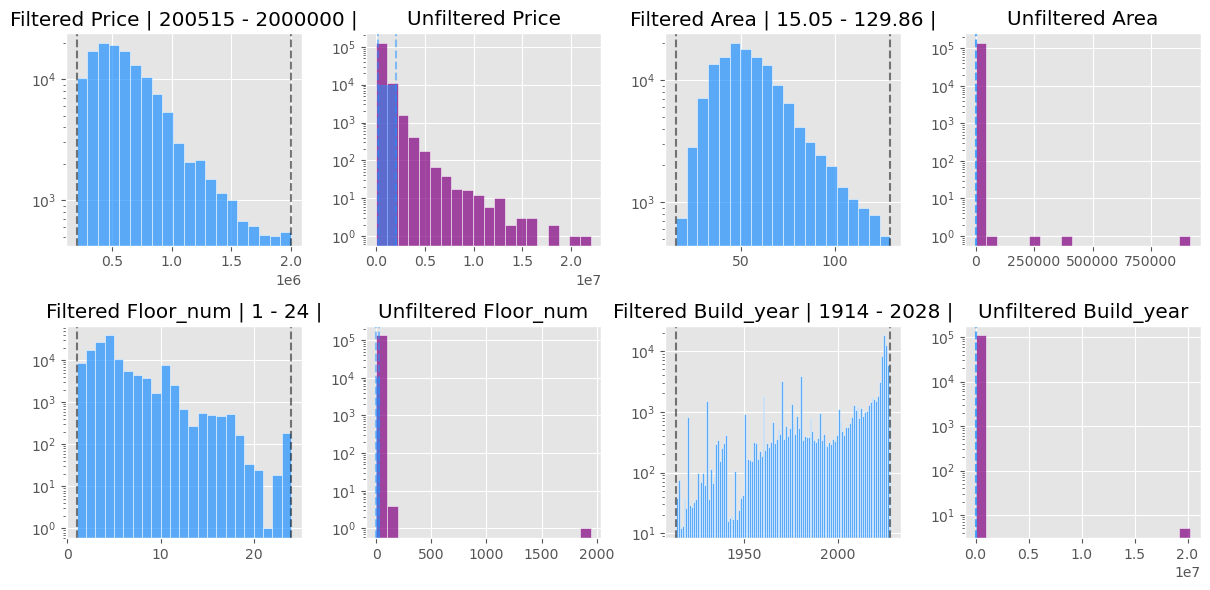

In [185]:
fig, axes = plt.subplots(figsize=(12,6), nrows=2, ncols=4, dpi=100)
axes = axes.flatten()
for idx, col in enumerate(NUMERICAL_COLS):
    col_data = df[~df[col].isna()][[col]]
    if col != "area":
        col_data = col_data.astype(int)
    unfiltered = col_data.copy()
    if col == "build_year":
        col_data = col_data[(col_data["build_year"] > 1900) & (col_data["build_year"] < 2030)]
    if col == "area":
        col_data = col_data[(col_data["area"] > 15) & (col_data["area"] < 300)]
    if col == "price":
        col_data = col_data[(col_data["price"] > 200_000) & (col_data["price"] < 5_000_000)]
    col_data["zscore"] = zscore(col_data[col])
    filtered = col_data[abs(col_data["zscore"]) <= 3]

    fil_min = filtered[col].min()
    fil_max = filtered[col].max()
    filtered_range = (fil_min, fil_max)
    filtered_bins = range(fil_min, fil_max+1) if col in ["rooms", "floor", "floor_num", "build_year"] else 20
    unfiltered_bins = 20

    x = np.linspace(fil_min, fil_max, 100)
    
    axes[2*(idx)].hist(filtered[col],
                 color="dodgerblue",
                 alpha=0.7,
                 edgecolor="white",
                 range=filtered_range,
                 bins=filtered_bins)
    axes[2*(idx)].axvline(fil_min, linestyle="--", color="black", alpha=0.5)
    axes[2*(idx)].axvline(fil_max, linestyle="--", color="black", alpha=0.5)
    axes[2*(idx)].set_yscale("log")
    axes[2*(idx)].set_title(f"Filtered {str(col).capitalize()} | {fil_min} - {fil_max} |")
    
    axes[2*(idx)+1].hist(unfiltered[col],
                 color="purple",
                 alpha=0.7,
                 edgecolor="white",
                 bins=unfiltered_bins)
    axes[2*(idx)+1].axvline(fil_min, linestyle="--", color="dodgerblue", alpha=0.5)
    axes[2*(idx)+1].axvline(fil_max, linestyle="--", color="dodgerblue", alpha=0.5)
    axes[2*(idx)+1].fill_between(x, 0, 10**4, where=(x >= fil_min) & (x <= fil_max), alpha=0.5, color="dodgerblue")
    axes[2*(idx)+1].set_yscale("log")
    axes[2*(idx)+1].set_title(f"Unfiltered {str(col).capitalize()}")

fig.tight_layout()
plt.show()

In [195]:
def get_IQRbounds(df: pd.DataFrame, col: str, bounds: tuple = None, iscont: bool = False, a: float = 1.5):
    col_data = df[~df[col].isna()][[col]]
    if not iscont:
        col_data = col_data.astype(int)
    if bounds:
        col_data = col_data[(col_data[col] >= bounds[0]) & (col_data[col] <= bounds[1])]
    Q1 = col_data[col].quantile(0.25)
    Q3 = col_data[col].quantile(0.75)
    IQR = Q3 - Q1
    return (Q1 - a*IQR, Q3 + a*IQR)

In [203]:
get_IQRbounds(df, "price", (150_000, 2_000_000))

(-171000.0, 1349000.0)

In [205]:
get_IQRbounds(df, "area", (15, 200))

(5.800000000000004, 102.6)

In [207]:
df["price"].quantile(0.01)

154000.0

In [209]:
df["price"].quantile(0.99)

2650000.0